# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Columns Info
Data columns (total 18 columns):
 
 id,
 region,
 price,
 year,
 manufacturer,
 model,
 condition,
 cylinders,
 fuel,
 odometer,
 title_status,
 transmission,
 VIN,
 drive,
 type,
 paint_color,
 state

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [194]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt # Often used alongside Seaborn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

In [195]:
df=pd.read_csv('data/vehicles.csv')


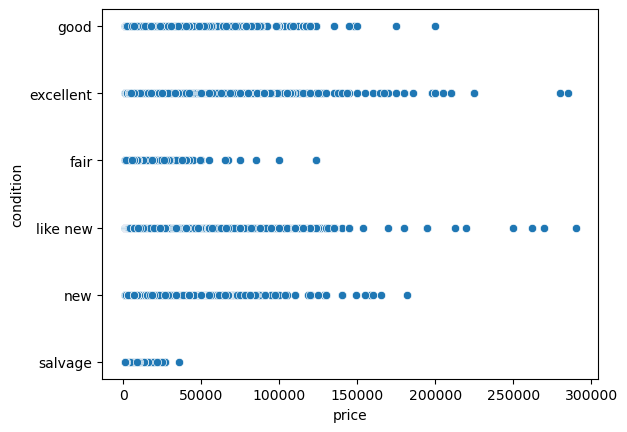

In [198]:
# Usually in a general sense, car condition should be directly proportional to price
# So lets see how the car condition is influencing the price.

df_price_range = df[df["price"].between(1000, 300000)]   # Dont consider extreme outliers for better plots
ax=sns.scatterplot(x='price',y='condition', data=df_price_range)
# While the general trend is clear, there's still a spread of prices within each condition category. 
# This suggests that other factors beyond just the broad condition categories might also 
# influence the final price (e.g., specific features, make/model if it were cars, mileage, etc.)
plt.show()

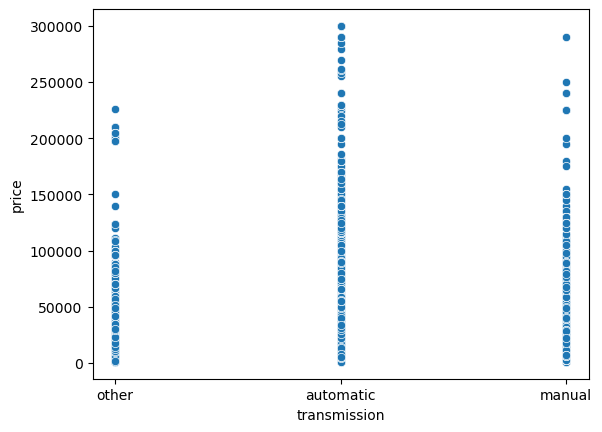

In [199]:
ax=sns.scatterplot(x='transmission',y='price', data=df_price_range)

# Clearly clean title cars have higher prices than lien,rebuilt, missing and parts only
plt.show()

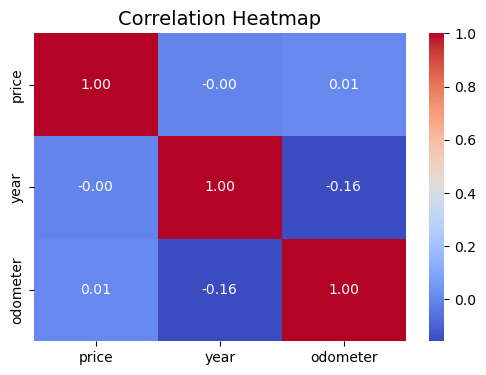

In [200]:
# Lets also see the correlation between numerical fields.

corr_columns=["price","year","odometer"]
df_crr=df[corr_columns]
plt.figure(figsize=(6, 4))
sns.heatmap(df_crr.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

# Apparently , the the odometer, year and price are NOT strongly correlated. 
# So the inference is some other factors such as categorical features are
# are influencing the price.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [201]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['odometer'] = pd.to_numeric(df['odometer'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['price'])
df = df[df['price'] > 0]

print('Before dropping na')
print(len(df))
df=df.dropna(subset=['year','odometer'])
print('After dropping na')
print(len(df))
print('Before dropping duplicates')
print(len(df))
df=df.drop_duplicates()
print('After dropping duplicates')
print(len(df))
df.info()

Before dropping na
393985
After dropping na
390585
Before dropping duplicates
390585
After dropping duplicates
390585
<class 'pandas.core.frame.DataFrame'>
Index: 390585 entries, 27 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            390585 non-null  int64  
 1   region        390585 non-null  object 
 2   price         390585 non-null  int64  
 3   year          390585 non-null  float64
 4   manufacturer  375619 non-null  object 
 5   model         385952 non-null  object 
 6   condition     241177 non-null  object 
 7   cylinders     231413 non-null  object 
 8   fuel          388459 non-null  object 
 9   odometer      390585 non-null  float64
 10  title_status  383363 non-null  object 
 11  transmission  389065 non-null  object 
 12  VIN           239574 non-null  object 
 13  drive         271075 non-null  object 
 14  size          110585 non-null  object 
 15  type          305248 n

In [202]:
# 2. Feature engineering
cond_map = {"new":5, "like new":4, "excellent":3, "good":2, "fair":1, "salvage":0}
df['condition_num'] = df['condition'].map(lambda x: cond_map.get(str(x).lower(), np.nan) if pd.notna(x) else np.nan)
df['cylinders_num'] = df['cylinders'].astype(str).str.extract('(\d+)').astype(float)

title_map = {'clean':6 ,'rebuilt':4, 'lien':5, 'salvage':1, 'missing':3, 'parts only':2}
df['title_status_num'] = df['title_status'].map(lambda x: title_map.get(str(x).lower(), np.nan) if pd.notna(x) else np.nan)


df['title_status_num'] = df['title_status_num'].fillna(df['title_status_num'].median())
df['condition_num'] = df['condition_num'].fillna(df['condition_num'].median())
df['cylinders_num'] = df['cylinders_num'].fillna(df['cylinders_num'].median())


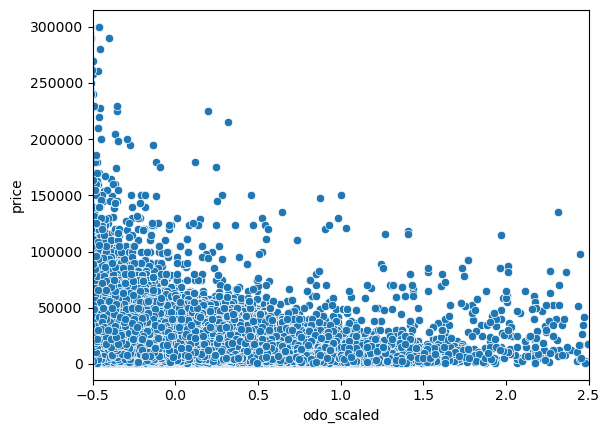

In [207]:
scaler = StandardScaler()

df_price_odometer = df_price_range[["price", "odometer"]].copy()
df_price_odometer.dropna()
df_price_odometer.drop_duplicates()

df_price_odometer['odo_scaled'] =scaler.fit_transform(df_price_odometer[['odometer']])
ax=sns.scatterplot(x='odo_scaled',y='price', data=df_price_odometer)
plt.xlim(-0.5, 2.5)
plt.show()
# Here we can observe the negative correlation between odometer and price. As odometer increases
# price decreases.

In [211]:
iqr = ''

###BEGIN SOLUTION

first_quartile = df['odometer'].quantile(.25)
third_quartile = df['odometer'].quantile(.75)
iqr = third_quartile - first_quartile
lower = first_quartile - 1.5*iqr
upper = third_quartile + 1.5*iqr

outliers_filtered = df.loc[(df['odometer']>lower) & (df['odometer']<upper)]

first_quartile = outliers_filtered['year'].quantile(.25)
third_quartile = outliers_filtered['year'].quantile(.75)
iqr = third_quartile - first_quartile
lower = first_quartile - 1.5*iqr
upper = third_quartile + 1.5*iqr

outliers_filtered = outliers_filtered.loc[(outliers_filtered['year']>lower) & (outliers_filtered['year']<upper)]




first_quartile = outliers_filtered['price'].quantile(.25)
third_quartile = outliers_filtered['price'].quantile(.75)
iqr = third_quartile - first_quartile
lower = first_quartile - 1.5*iqr
upper = third_quartile + 1.5*iqr

outliers_filtered = outliers_filtered.loc[(outliers_filtered['price']>lower) & (outliers_filtered['price']<upper)]


print(len(outliers_filtered))
# count in salaries_no_outlier 34516
# while count in original df is 34868. So we managed to remove 350 outliers.

364776


In [212]:
#drop condition since already converted to num
outliers_filtered.drop("condition",axis=1,inplace=True,errors='ignore')

#drop cylinders since already converted to num
outliers_filtered.drop("cylinders",axis=1,inplace=True,errors='ignore')

##Apparently VINs are not unique. So better to drop.
outliers_filtered.drop("VIN",axis=1,inplace=True,errors='ignore')

##Apparently VINs are not unique. So better to drop.
outliers_filtered.drop("title_status",axis=1,inplace=True,errors='ignore')


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [215]:

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
# Features and target
X = outliers_filtered.drop("price", axis=1)
y = outliers_filtered["price"]


# Pipeline
pipe = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("selector", SequentialFeatureSelector(Ridge(), n_features_to_select=10)),
    ("ridge", Ridge())
])

# Define parameter grid
param_grid = {
    "poly__degree": [2],
    "ridge__alpha": [0.01, 0.1, 1, 10, 100],
}

# GridSearchCV
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1
)

# Fit
grid.fit(X_train, y_train)

# Best params and estimator
print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

# Evaluate on test set
y_pred = grid.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test R2:", r2_score(y_test, y_pred))

Best Parameters: {'poly__degree': 2, 'ridge__alpha': 0.01}
Best CV Score: 0.5181403348835777
Test MSE: 78655047.05596495
Test R2: 0.5223550793104561


34868
34868
150208407.76530823
Predicted price: $26,897.07


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.